In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as pp
import numpy as np
import csv
import os

from matplotlib import cm
from numpy import arctan, log, pi, sqrt

from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib notebook

os.chdir("D:")

In [2]:
nx  = 50
ny  = 50
nt  = 300

xmin = -5
xmax = 5
ymin = 0
ymax = 10

dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)
dt = 0.01

x  = np.linspace(xmin, xmax, nx)
y  = np.linspace(xmin, xmax, ny)

X, Y = np.meshgrid(x, y)

L = ymax

In [3]:
u  = np.zeros((nx, ny))
un = np.zeros((nx, ny))

v  = np.zeros((nx, ny))
vn = np.zeros((nx, ny))

T  = np.zeros((nx, ny))
Tn = np.zeros((nx, ny))

C  = np.zeros((nx, ny))
Cn = np.zeros((nx, ny))

In [4]:
a      = 1
beta   = 0.0001 #unsteadiness paramepter
nu     = 0.000829
rho    = 997.5
mu0    = 4e-7*pi
M      = 8.6e5
h      = 12.5e-6   #height of magnet
w      = 25e-6     #width of magnet
c      = 4178      #spcefic heat  Cp
Cv     = 4.15
eps    = 0.2
tau    = c/Cv
Q0     = 50 #heat generation
mu     = 0.001
H0     = 253843.822358745
kf     = 0.6129
kp     = 80.4
gamma2 = 0.2

In [5]:
V0    = -5
ts    = nt*dt #Final time
Cf    = 0.2/100
Cinf  = 0.4/100
delC  = Cf - Cinf
Tinf  = 333
Tf    = 293 #initial Temp
delT  = Tf - Tinf
alpha = kf/(rho*c)  #thermal diffusity
Pr    = nu/alpha
Re    = V0*L/nu
# Nu = 0.05928 * ((0.44 + Cf)**0.536) * Re**0.7 * Pr**0.4
Nu    = 0.45
hf    = kf*Nu/L

In [6]:
kB = 1.385e-23
dp = 1e-8 #particle diameter
TF = (Tinf + Tf)/2 #Film temperature
DB = (kB*TF)/(3 * pi * mu * dp)

In [7]:
DT = (mu/rho) * (0.26 * kf/(kf + kp))

In [8]:
hm = gamma2 * DB * sqrt(alpha/nu)

In [9]:
def Hcalc(M, i, j, h, w):
    H = (sqrt(M**2*(-log(((-h + j)**2 +
                          (-w + i)**2)/((h + j)**2 +
                          (-w + i)**2)) +
                          log(((-h + j)**2 + (w + i)**2)/((h + j)**2 +
                          (w + i)**2)))**2/(16*pi**2) +
                          M**2*(-arctan(2*h*(-w + i)/(-h**2 + j**2 +
                          (-w + i)**2)) + arctan(2*h*(w + i)/(-h**2 + j**2 + (w + i)**2)))**2/(4*pi**2)))
    H = H/H0
    return H

In [10]:
#Boundary conditions #1

T[:, 1]    = (dy * Nu) + T[:, 0]      # y = 0
C[:, 1]    = ((hm*L*dy)/DB) + C[:, 0] # y = 0
T[:, ny-1] = -1 # y = oo
C[:, ny-1] = -1 # y = oo
v[:, ny-1] = 0    # y = oo

In [11]:
#Boundary conditions #2

for n in range(nt): # n = t
    for i in range(nx):
        u[i, ny-1] = (a*L*i)/(V0 * (1-beta*ts*n))    # y = oo
        u[i, 0]    = (a*L*i)/(V0 * (1-(beta*ts*n))) # y = 0
        v[i, 0]    = (-1)/sqrt((1-(beta*ts*n)))

In [12]:
def diff1(i, j, F, d, var): #derivative 1
    if (var == "x"):
        dF = (F[i+1, j] - F[i, j])/d
    elif (var == "y"):
        dF = (F[i, j+1] - F[i, j])/d
    return dF

In [13]:
def diff2(i, j, F, d, var): #derivative 2
    if (var == "x"):
        d2F = (F[i+1, j] - 2*F[i, j] + F[i-1, j])/(2*d)
    elif (var == "y"):
        d2F = (F[i, j+1] - 2*F[i, j] + F[i, j-1])/(2*d)
    return d2F

In [14]:
def Hdiff(i, j, d, var):
    if (var == "x"):
        dH = (Hcalc(M, i+1, j, h, w) - Hcalc(M, i, j, h, w))/d
    elif (var == "y"):
        dH = (Hcalc(M, i, j+1, h, w) - Hcalc(M, i, j, h, w))/d
    return dH

In [15]:
u.fill(a*L/V0)
v.fill(V0)
T.fill(Tf)
C.fill(Cf)

In [ ]:
udiff     = 1
Tdiff     = 1
Cdiff     = 1
stepcount = 0
accu      = 0.001

iteration = []

udiffDat = []
TdiffDat = []
CdiffDat = []

In [ ]:
def init():
    line.set_data([], [])
    return (line)

In [ ]:
def animate(iteration, udiffDat, TdiffDat, CdiffDat):
    xs = []
    it = []
    US = []
    TS = []
    VS = []
    for i in range(len(iteration)):
        if len(line) > 1:
            xs.append(iteration)
            US.append(udiffDat)
            TS.append(TdiffDat)
            VS.append(CdiffDat)
    
    ax.clear()
    ax.plot(xs, US)
    ax.plot(xs, TS)
    ax.plot(xs, VS)

In [16]:
#Itertion
fig, ax = pp.subplots()

while (udiff > accu) and (Tdiff > accu) and (Cdiff > accu):
    un = u.copy()
    vn = v.copy()
    Tn = T.copy()
    Cn = C.copy()

    for n in range(nt):
        for i in range(nx-2):
            for j in range(1, ny-2):
                #Velocity
                u[i, j] = (((ts*dt)/V0) * ((a*L*i*(a+beta))/(1-beta*ts*nt) + 
                                           ((nu*V0)/(L**2)) * diff2(i, j, un, dy, "y") + 
                                           ((1/rho)*mu0*M*H0/L) * Hdiff(i, j, dx, "x") -
                                           (((V0**2)/L) * un[i, j] * diff1(i, j, un, dx, "x") +
                                           (((V0**2)/L) * vn[i, j] * diff1(i, j, un, dy, "y")))
                                          + un[i, j]))

                #Temperature
                T[i, j] = (((ts*dt)/delT) * (tau *
                                             ((DB/(L**2)) * delC * (delT) * diff1(i, j, Cn, dy, "y") * diff1(i, j, Tn, dy, "y")) + 
                                             (DT/(Tinf * (L**2))) * (delT**2) * ((diff1(i, j, Tn, dy, "y"))**2)) + 
                                             (Q0/(rho*c)) * delT * (Tn[i, j] + 1) - 
                                             ((V0/L) * un[i, j] * delT * diff1(i, j, Tn, dx, "x") + 
                                             (V0/L) * vn[i, j] * delT * diff1(i, j, Tn, dy, "y"))
                                              + Tn[i, j])
                #Concentration
                C[i, j] = (((ts*dt)/delC) * ((DB/(L**2)) * delC * diff2(i, j, Cn, dy, "y") +
                                            (DT/((L**2)*Tinf)) * delT * diff1(i, j, Tn, dy, "y") - 
                                            ((V0/L) * un[i, j] * delC * diff1(i, j, Cn, dx, "x") + 
                                            (V0/L) * vn[i, j] * delC * diff1(i, j, Cn, dy, "y"))) +
                                             Cn[i, j])




                udiff = (np.sum(u) - np.sum(un))/np.sum(u)
                Tdiff = (np.sum(T) - np.sum(Tn))/np.sum(T)
                Cdiff = (np.sum(C) - np.sum(Cn))/np.sum(C)

                #print("udiff = " + str(udiff), "; Tdiff = " + str(Tdiff), " Cdiff = " + str(Cdiff))

                stepcount += 1

                
                udiffDat.append(udiff)
                TdiffDat.append(Tdiff)
                CdiffDat.append(Cdiff)
                iteration.append(stepcount)


#                 if (abs(udiff) > 0) or (abs(Tdiff) > 0) or (abs(Cdiff) > 0):
#                     break

<IPython.core.display.Javascript object>


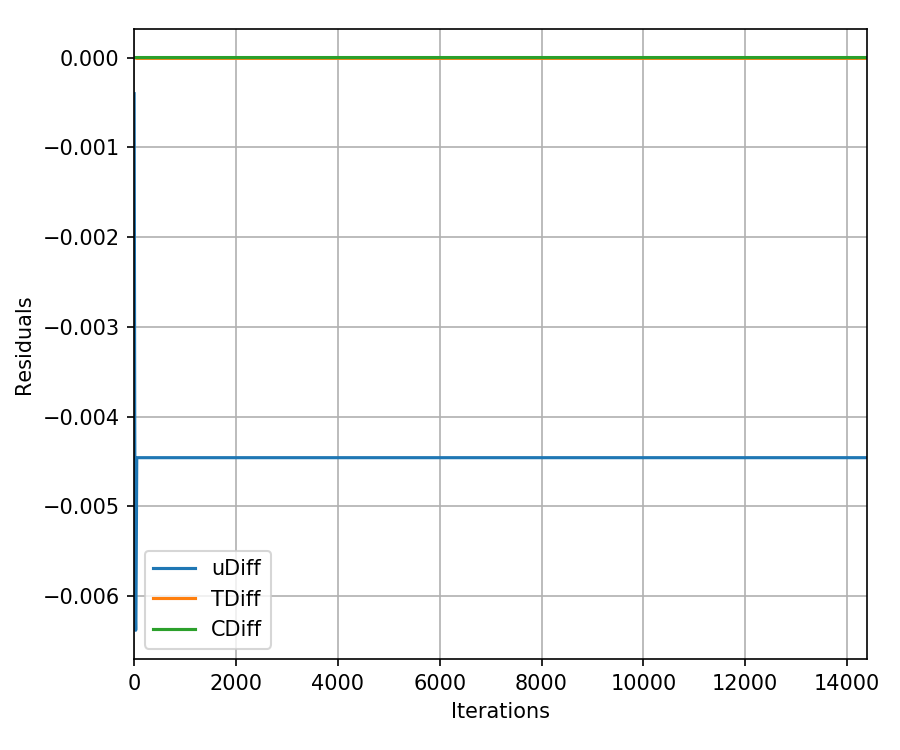

In [17]:
%matplotlib notebook

xu = np.linspace(0, stepcount, stepcount)

pp.figure()

pp.autoscale(enable=True, axis='x', tight=True)

pp.plot(xu, udiffDat, label = "uDiff")
pp.plot(xu, TdiffDat, label = "TDiff")
pp.plot(xu, CdiffDat, label = "CDiff")

pp.grid(True)
pp.legend();
pp.xlabel("Iterations")
pp.ylabel("Residuals")

pp.tight_layout()
fig = pp.gcf()
fig.set_size_inches(6, 5)

<IPython.core.display.Javascript object>


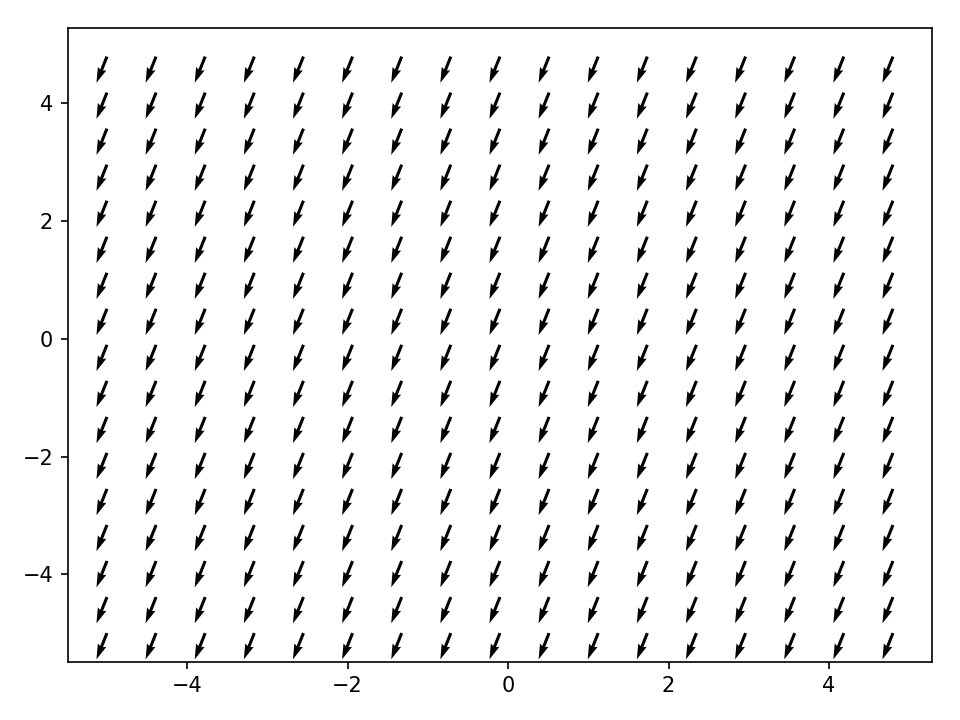

In [18]:
pp.figure()
z = 3
pp.quiver(X[::z, ::z], Y[::z, ::z], u[::z, ::z], v[::z, ::z]);
pp.tight_layout()

<IPython.core.display.Javascript object>


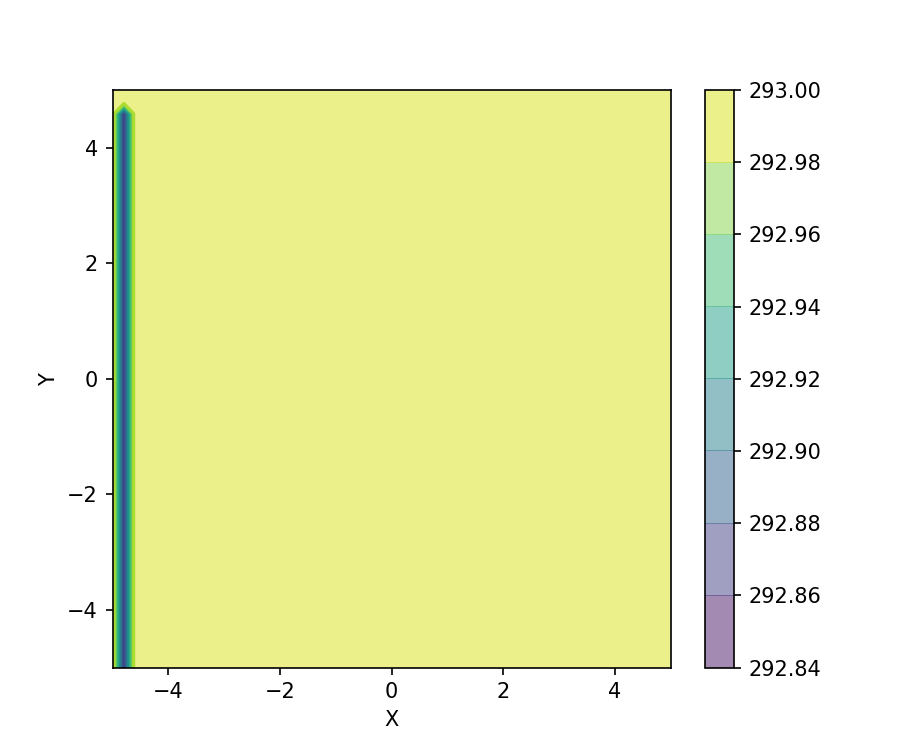

In [19]:
fig = pp.figure()

pp.contourf(X, Y, T, alpha=0.5, cmap=cm.viridis)  
pp.colorbar()

pp.contour(X, Y, T, cmap=cm.viridis)  
# plotting velocity field
# pp.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
pp.xlabel('X')
pp.ylabel('Y');

fig = pp.gcf()
fig.set_size_inches(6, 5)

In [20]:
udiff

-0.004458779719192959